### 1. Get our data cubes from files

In [1]:
# For parallelization, which helps to make convolution faster
import dask
dask.config.set(scheduler = 'threads', num_workers = 8)
from dask.diagnostics import ProgressBar
ProgressBar().register()
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy import units as u

results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

In [3]:
# Get names of spectral windows
# I think these are in vaguely the right order?
freq_spws = [
'87_spw25',
# '87_spw102', # duplicate of above
'89_spw27',
# '89_spw104', # duplicate of above

'91_spw25', 
# '91_spw102', # duplicate of above
'93_spw27',
# '93_spw104', # duplicate of above
'95_spw25', 
'97_spw27', 
'98_spw29',
# '98_spw106', # duplicate of above
# '99_spw25', # duplicate of above
'99_spw31',  
# '99_spw108', # duplicate of above

# '101_spw27', # duplicate of above
'102_spw23',
'102_spw29', 
# '102_spw106', # duplicate of above
'104_spw25', # mislabeled, should be before 103_spw31
'103_spw31', 
# '103_spw108', # duplicate of above
'106_spw29',
'107_spw31',

'110_spw29',
'111_spw31',
'112_spw27',
'114_spw29',

'127_spw65', 
'129_spw67',

'130_spw105',
'132_spw107',
'134_spw45', 
'135_spw47',
'137_spw85',
'137_spw69',
# '139_spw87', # duplicate of above
'139_spw71',
# '141_spw25', # duplicate of above

'140_spw109',
'142_spw111',
'144_spw49',
'146_spw51',
'147_spw89',
'149_spw91',

'142_spw27', # mislabeled
# '151_spw29', # duplicate of above
'152_spw31',

'244_spw65',
'245_spw67',
'247_spw105',
'249_spw107',

'250_spw25',
'252_spw27',
'254_spw85',
'255_spw87',
'257_spw45',
'259_spw47',
# '258_spw69', # significant overlap with above?
'259_spw71',

'261_spw109',
'263_spw111',
'264_spw29',
'266_spw31',
'268_spw89',

'270_spw91',
'271_spw49',
'273_spw51'
]

In [4]:
# Only look at one cube from here on out
ind = freq_spws.index('110_spw29')

In [5]:
from spectral_cube import SpectralCube

cube = SpectralCube.read(results+'source_ab_'+freq_spws[ind]+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image', use_dask = True)

### 2. Convert cube to a common beam

Skipping converting all cubes to a common beam because I only want to examine one spectrum at a time.

In [6]:
cube_common_beam = cube.beams.common_beam(max_iter = 20, max_epsilon = 0.01)
smoothed_cube = cube.convolve_to(cube_common_beam) # Convert from VaryingResolution to regular

# import radio_beam

# beams = []
# for cube in smoothed_cubes:
#     beams.append(cube.beam)

# common_beam = radio_beam.commonbeam.common_manybeams_mve(radio_beam.Beams(beams = beams)) # Get common beam between all cubes
# common_beam

In [7]:
# resampled_cubes = []
# for cube in smoothed_cubes:
#     resampled_cube = cube.convolve_to(common_beam) # This cell takes almost no time; the cubes do not get convolved in this step
#     resampled_cubes.append(resampled_cube)

### 3. Extract spectrum and plot our data

In [8]:
# Extract spectrum for a coordinate in central core region
from astropy import coordinates
from astropy import wcs

crd = coordinates.SkyCoord("17:46:10.63 -28:42:17.8", frame='fk5', unit=(u.h, u.deg))

x, y = map(int, smoothed_cube.wcs.celestial.world_to_pixel(crd))

In [9]:
# # Extract spectrum for brightest pixel in central core region
# import regions
# reg = regions.Regions.read('/blue/adamginsburg/abulatek/brick/first_results/region_temperatures/centralcoreellipse.reg')

# smoothed_cube_reg = smoothed_cube.subcube_from_regions(reg)

In [34]:
# m0 = smoothed_cube.moment0()
m0 = smoothed_cube[0] # HACK to make go faster

In [11]:
# Take the mean spectrum of the outflow cavity region
import regions

reg = regions.Regions.read('outflow_cavity_region.reg')
smoothed_scube = smoothed_cube.subcube_from_regions(reg)
mean_spectrum = smoothed_scube.mean(axis = (1, 2)) #how='slice', progressbar=True

[########################################] | 100% Completed | 4.24 sms
[########################################] | 100% Completed | 3.19 sms
[########################################] | 100% Completed | 90.59 s


make: *** No targets specified and no makefile found.  Stop.


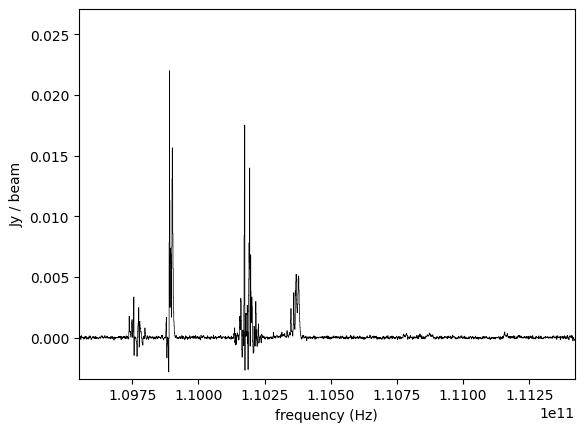

In [12]:
# THIS IS ADAM'S HACKERY
import pyspeckit
sp = pyspeckit.Spectrum(xarr=mean_spectrum.spectral_axis, data=mean_spectrum)
sp.plotter()

[Param #0   AMPLITUDE0 =         0.03,
 Param #1       SHIFT0 =       127.35,
 Param #2       WIDTH0 =        0.001  Range:   [0,inf),
 Param #3   AMPLITUDE1 =        0.003,
 Param #4       SHIFT1 =       127.37,
 Param #5       WIDTH1 =        0.001  Range:   [0,inf)]

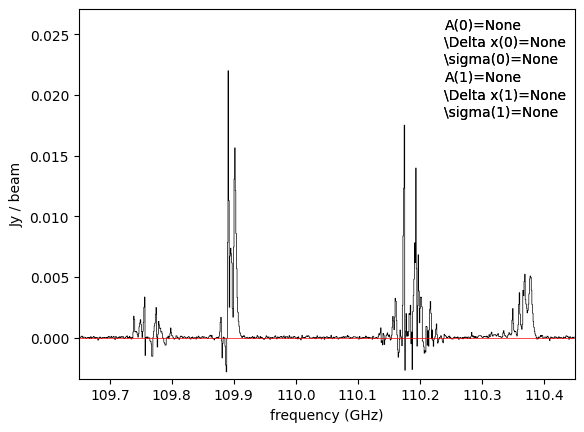

In [22]:
sp.xarr.convert_to_unit(u.GHz)
sp.plotter(xmin=109.65*u.GHz, xmax=110.45*u.GHz)
sp.specfit(guesses=[0.03, 127.35, 0.001, 0.003, 127.37, 0.001])
sp.specfit.parinfo

In [23]:
from astropy import constants

In [24]:
v1 = -(sp.specfit.parinfo['SHIFT0'] - 127.36766)/127.36766*constants.c.to(u.km/u.s)
v2 = -(sp.specfit.parinfo['SHIFT1'] - 127.36766)/127.36766*constants.c.to(u.km/u.s)
v1,v2

(<Quantity 41.56733984 km / s>, <Quantity -5.50779022 km / s>)

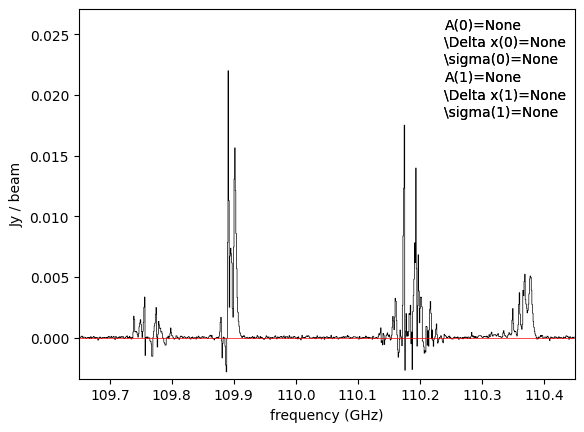

In [26]:
sp.xarr.convert_to_unit(u.GHz)
sp.plotter(xmin=109.65*u.GHz, xmax=110.45*u.GHz)
sp.specfit(guesses=[0.03, 127.84, 0.001, 0.003, 127.85, 0.001])
#sp.specfit.parinfo

In [27]:
f1 = (sp.specfit.parinfo['SHIFT0'] * (1+ v1/constants.c.to(u.km/u.s)))
f2 = (sp.specfit.parinfo['SHIFT1'] * (1+ v2/constants.c.to(u.km/u.s)))
f1,f2

(<Quantity 127.85772549>, <Quantity 127.84765114>)

In [29]:
# from astroquery.splatalogue import Splatalogue, utils
# utils.minimize_table(Splatalogue.query_lines(f1*u.GHz*(1-5/3e5), f1*(1+5/3e5)*u.GHz))

In [30]:
import matplotlib.pyplot as plt

SM_SIZE = 12
MD_SIZE = 18
LG_SIZE = 22

plt.rc('font', size = MD_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = LG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MD_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SM_SIZE)    # legend fontsize
plt.rc('figure', titlesize = LG_SIZE)   # fontsize of the figure title

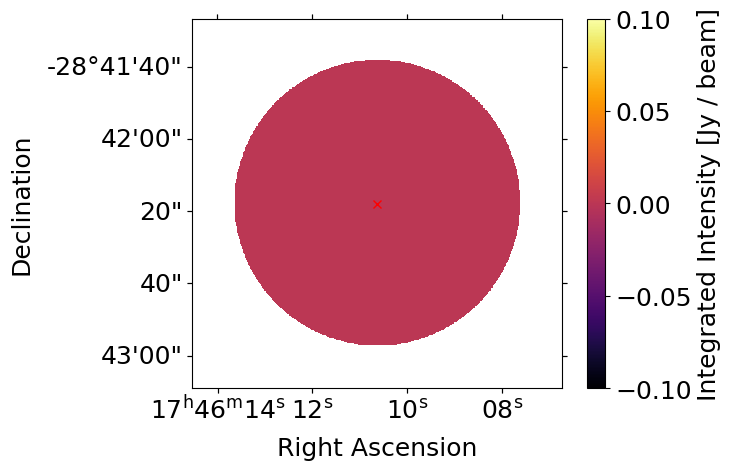

In [31]:
ax = plt.subplot(projection = m0.wcs)
plt.plot(x, y, marker = 'x', color = 'r')
im = ax.imshow(m0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label(f'Integrated Intensity [{m0.unit}]')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

In [32]:
spectrum = smoothed_cube[:, y, x].to(u.K)

[############                            ] | 31% Completed | 25.48 ss


KeyboardInterrupt: 

In [ ]:
import numpy as np

fig = plt.figure(figsize = (30, 8))

plt.plot(smoothed_cube.spectral_axis.to(u.GHz), np.array(spectrum), linestyle = '-', color = 'k', linewidth = 1, drawstyle = 'steps-mid')
plt.xlabel(f"Frequency [{smoothed_cube.spectral_axis.to(u.GHz).unit}]")
plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
plt.title(f"{freq_spws[ind]} data spectrum")
plt.show()

### 4. Generate XCLASS model of the same spectral window

In [ ]:
# Get path of XCLASS directory
import os
import sys
XCLASSRootDir = str(os.environ.get('XCLASSRootDir', '')).strip()
XCLASSRootDir = os.path.normpath(XCLASSRootDir) + "/"

# Extend sys.path variable
NewPath = XCLASSRootDir + "build_tasks/"
if (not NewPath in sys.path):
    sys.path.append(NewPath)

import task_myXCLASS

In [ ]:
# source_size =  0.33 # total guess, but based on Dan's data? also, not used
tkin = 151 # 7.9842254347e+01
Ntot = 5.0e+13 # 10**N_tot # 1.5061155735e+14 # 1.0061155735e+16
# vwidth_fwhm = 4.21
# vwidth = vwidth_fwhm / np.sqrt(8*np.log(2))
# vcen = 38.0
# tbg = 0

In [ ]:
# Define path and name of molfit file
# DEFAULT MolfitsFileName = LocalPath + "files/my_molecules.molfit"
LocalPath = os.getcwd() + "/"

MolfitsFileName = LocalPath + 'my_molecules-tout.molfit'

# def set_xclass_parameters(source_size=source_size, tkin=tkin, Ntot=Ntot, vwidth_fwhm=vwidth_fwhm, vcen=vcen, filename=MolfitsFileName):
#     with open(filename, "w") as fh:
#         fh.write(f"""
# %============================================================================================================================
# %
# % define molecules and their components:
# %
# %============================================================================================================================
# %    source size:                 T_kin:               N_tot:            V_width:                V_off:   CFFlag:    keyword:
# %       [arcsec]:                   [K]:              [cm-2]:            [km /s]:              [km /s]:       []:         []:
# CH3CN;v=0;           1
#  {source_size}       {tkin}     {Ntot}     {vwidth_fwhm}    {vcen}         c
# """)

In [ ]:
# define freq. step (in MHz)
FreqStep = 0.1

# define beam minor axis length (in arsec)
BMIN = smoothed_cube.beam.minor.to(u.arcsec).value # None

# define beam major axis length (in arsec)
BMAJ = smoothed_cube.beam.major.to(u.arcsec).value # None

# define beam position angle (in degree)
BPA = smoothed_cube.beam.pa.to(u.deg).value # None

# depending on parameter "Inter_Flag" define beam size (in arcsec)
# (Inter_Flag = True) or size of telescope (in m) (Inter_Flag = False)
TelescopeSize = np.abs(BMIN**2 - BMAJ**2)**0.5 # arcsec # 1000.0 # meters

# interferometric data?
Inter_Flag = True

# define red shift
Redshift = None

# BACKGROUND: describe continuum with tBack and tslope only
t_back_flag = True

# BACKGROUND: define background temperature (in K)
tBack = 0.0

# BACKGROUND: define temperature slope (dimensionless)
tslope = 0.0

# BACKGROUND: define path and name of ASCII file describing continuum as function
#             of frequency
BackgroundFileName = ""

# DUST: define hydrogen column density (in cm^(-2))
N_H = 1.e22

# DUST: define spectral index for dust (dimensionless)
beta_dust = 0.0

# DUST: define kappa at 1.3 mm (cm^(2) g^(-1))
kappa_1300 = 0.0

# DUST: define path and name of ASCII file describing dust opacity as
#       function of frequency
DustFileName = ""

# FREE-FREE: define electronic temperature (in K)
Te_ff = None

# FREE-FREE: define emission measure (in pc cm^(-6))
EM_ff = None

# SYNCHROTRON: define kappa of energy spectrum of electrons (electrons m^(−3) GeV^(-1))
kappa_sync = None

# SYNCHROTRON: define magnetic field (in Gauss)
B_sync = None

# SYNCHROTRON: energy spectral index (dimensionless)
p_sync = None

# SYNCHROTRON: thickness of slab (in AU)
l_sync = None

# PHEN-CONT: define phenomenological function which is used to describe
#            the continuum
ContPhenFuncID = None

# PHEN-CONT: define first parameter for phenomenological function
ContPhenFuncParam1 = None

# PHEN-CONT: define second parameter for phenomenological function
ContPhenFuncParam2 = None

# PHEN-CONT: define third parameter for phenomenological function
ContPhenFuncParam3 = None

# PHEN-CONT: define fourth parameter for phenomenological function
ContPhenFuncParam4 = None

# PHEN-CONT: define fifth parameter for phenomenological function
ContPhenFuncParam5 = None

# use iso ratio file?
iso_flag = True

# define path and name of iso ratio file
#DEFAULT IsoTableFileName = LocalPath + "files/my_isonames.txt"
IsoTableFileName = LocalPath + "my_isonames.txt"

# define path and name of file describing Non-LTE parameters
CollisionFileName = ""

# define number of pixels in x-direction (used for sub-beam description)
NumModelPixelXX = 100

# define number of pixels in y-direction (used for sub-beam description)
NumModelPixelYY = 100

# take local-overlap into account or not
LocalOverlapFlag = False

# disable sub-beam description
NoSubBeamFlag = True

# define path and name of database file
dbFilename = ""

# define rest freq. (in MHz)
RestFreq = 0.0

# define v_lsr (in km/s)
vLSR = 0.0

In [ ]:
import io
from contextlib import redirect_stdout

def myxclass_call(FreqMin=1e3, FreqMax=1e4, verbose=False):
    ## call myXCLASS function
    print(MolfitsFileName)
    with io.StringIO() as buf, redirect_stdout(buf):
        modeldata, log, TransEnergies, IntOpt, JobDir = task_myXCLASS.myXCLASS(
                                                    FreqMin, FreqMax, FreqStep,
                                                    TelescopeSize, BMIN, BMAJ,
                                                    BPA, Inter_Flag, Redshift,
                                                    t_back_flag, tBack, tslope,
                                                    BackgroundFileName,
                                                    N_H, beta_dust, kappa_1300,
                                                    DustFileName, Te_ff, EM_ff,
                                                    kappa_sync, B_sync, p_sync,
                                                    l_sync, ContPhenFuncID,
                                                    ContPhenFuncParam1,
                                                    ContPhenFuncParam2,
                                                    ContPhenFuncParam3,
                                                    ContPhenFuncParam4,
                                                    ContPhenFuncParam5,
                                                    MolfitsFileName, iso_flag,
                                                    IsoTableFileName,
                                                    CollisionFileName,
                                                    NumModelPixelXX,
                                                    NumModelPixelYY,
                                                    LocalOverlapFlag,
                                                    NoSubBeamFlag,
                                                    dbFilename,
                                                    RestFreq, vLSR)
        output = buf.getvalue()
    if verbose:
        print(output)
        
    return modeldata, log, TransEnergies, IntOpt, JobDir

In [ ]:
# define min. freq. (in MHz)
FreqMin = np.min(spectrum.spectral_axis.to(u.MHz)).value
# define max. freq. (in MHz)
FreqMax = np.max(spectrum.spectral_axis.to(u.MHz)).value

In [ ]:
# # set_xclass_parameters() # The molfit file is already created, I don't want to mess with it; to run this, need to uncomment function definition a few cells ago
# modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)

In [ ]:
# fig = plt.figure(figsize = (30, 8))

# plt.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], linestyle = '-', color = 'r', linewidth = 1, drawstyle = 'steps-mid')
# plt.xlabel(f"Frequency [{(modeldata[:,0]*u.MHz).to(u.GHz).unit}]")
# plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
# plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
# plt.title(f"{freq_spws[ind]} model spectrum, $T$ = {tkin:.1f} K, $\log_{{10}}(N_{{tot}})$ = {np.log10(Ntot):.2f}") # y = 0.92
# plt.show()

### 5. Overplot our data and the XCLASS model

In [ ]:
# Preliminary continuum subtraction
spectrum_contsub = np.array(spectrum) - np.median(np.array(spectrum))

In [ ]:
# fig = plt.figure(figsize = (30, 8))

# plt.plot(smoothed_cube.spectral_axis.to(u.GHz), spectrum_contsub, linestyle = '-', color = 'k', linewidth = 0.75, drawstyle = 'steps-mid', 
#          label = "Data")
# plt.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], linestyle = '--', color = 'r', linewidth = 1, drawstyle = 'steps-mid', 
#          label = "Model")
# plt.legend(loc='best')
# plt.xlabel(f"Frequency [{smoothed_cube.spectral_axis.to(u.GHz).unit}]")
# plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
# plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
# plt.title(f"{freq_spws[ind]} data and model comparison, $T$ = {tkin:.1f} K, $\log_{{10}}(N_{{tot}})$ = {np.log10(Ntot):.2f}") # y = 0.92
# plt.show()

### 6. Repeat, but make a model for each molecule separately

In [ ]:
import glob
MolfitsFileNames = glob.glob(LocalPath + 'individuals/*.molfit')

In [ ]:
MolfitsFileNames[13]

In [ ]:
MolfitsFileName = '/blue/adamginsburg/abulatek/brick/first_results/lots_of_plotting/all/individuals/HC3Nv=0.molfit'
modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)

In [ ]:
modeldata_all = []
transenergies_all = []
for MolfitsFileName in MolfitsFileNames:
    print(MolfitsFileName)
    modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)
    modeldata_all.append(modeldata)
    transenergies_all.append(TransEnergies)

In [ ]:
# User-maintained color list
colors = {'13CO;v=0;'   : ['tab:blue',   '--'],
          'CCCS;v=0;'   : ['tab:orange', '--'],
          'CCH;v=0;'    : ['tab:green',  '--'],
          'CCS;v=0;'    : ['tab:red',    '--'],
          'CH3CN;v=0;'  : ['tab:purple', '--'],
          'CH3OH;v=0;'  : ['tab:pink',   '--'],
          'CO;v=0;'     : ['tab:olive',  '--'],
          'H2CS;v=0;'   : ['tab:cyan',   '--'],
          'HC3N;v=0;'   : ['tab:blue',   '-.'],
          'HCN;v=0;'    : ['tab:orange', '-.'],
          'HCO+;v=0;'   : ['tab:green',  '-.'],
          'HDCO;v=0;'   : ['tab:red',    '-.'],
          'HNCO;v=0;'   : ['tab:purple', '-.'],
          'HNC;v=0;'    : ['tab:pink',   '-.'],
          'HOCO+;v=0;'  : ['tab:olive',  '-.'],
          'N2H+;v=0;'   : ['tab:cyan',   '-.'],
          'NH2D;v=0;'   : ['tab:blue',   ':'],
          'NH3;v=0;'    : ['tab:orange', ':'],
          'OCS;v=0;'    : ['tab:green',  ':'],
          'C17O;v=0;'   : ['tab:red',    ':'],
          'H13CO+;v=0;' : ['tab:purple', ':'],
          '13CO;v=0;'   : ['tab:pink',   ':'],
          'HC15N;v=0;'  : ['tab:olive',  ':'],
          'HN13C;v=0;'  : ['tab:cyan',   ':'],
          'C18O;v=0;'   : ['tab:blue',   (0,(3,1,1,1,1,1))],
          #'H2COH+;v=0;' : ['tab:orange', (0,(3,1,1,1,1,1))],
          'NH2CHO;v=0;' : ['tab:green',  (0,(3,1,1,1,1,1))],
          'H13CN;v=0;'  : ['tab:red',    (0,(3,1,1,1,1,1))],
         }
# to add: C3H2, CH3OCHO, CH3OCH3, H2CO, SO, SO2, 13CS, CS, CN
# column densities: {'CO': 1e18, '13CO': 1e17, 'H2CO': 1e16, 'CH3OH': 1e15, 'CH3OCHO': 1e14, 'CH3OCH3': }

In [ ]:
# fig = plt.figure(figsize = (30, 8))

# for index, (modeldata, transenergies) in enumerate(zip(modeldata_all, transenergies_all)):
#     if len(modeldata) != 0:
#         colorname = transenergies[1][-1]
#         molname = MolfitsFileNames[index].replace('/blue/adamginsburg/abulatek/brick/first_results/lots_of_plotting/all/individuals/', '').replace('.molfit', '')
#         plt.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], colors[colorname], linewidth = 1, drawstyle = 'steps-mid', 
#                  label = molname)
#         plt.xlabel(f"Frequency [{(modeldata[:,0]*u.MHz).to(u.GHz).unit}]")
#     else:
#         print(f"***** Warning! {molname} was not modeled! *****")
# plt.legend(loc = 'best')
# plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
# plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
# plt.title(f"{freq_spws[ind]} model spectrum, $T$ = {tkin:.1f} K, $\log_{{10}}(N_{{tot}})$ = {np.log10(Ntot):.2f}") # y = 0.92 # NOTE: TKIN AND NTOT MAY CHANGE WHEN WE FIT !
# plt.show()

In [ ]:
from astropy.stats import mad_std

# Get MAD-estimated RMS of data spectrum
mad_rms = mad_std(spectrum_contsub)

In [ ]:
# # Set up color and linestyle cycler
# from cycler import cycler
# plt.rc('axes', prop_cycle=(cycler('color', ['xkcd:azure', 'xkcd:orange', 'xkcd:teal', 'xkcd:magenta']) * cycler('linestyle', ['--', ':', '-.', (0,(3,1,1,1,1,1))])))

In [ ]:
fig = plt.figure(figsize = (30, 8))

plt.plot(smoothed_cube.spectral_axis.to(u.GHz), spectrum_contsub, linestyle = '-', color = 'grey', linewidth = 1, drawstyle = 'steps-mid', 
        label = "Data")
plt.axhspan(ymin = -mad_rms, ymax = mad_rms, alpha = 0.25, color = 'k', label = 'RMS level in data')
for index, (modeldata, transenergies) in enumerate(zip(modeldata_all, transenergies_all)):
    molname = MolfitsFileNames[index].replace('/blue/adamginsburg/abulatek/brick/first_results/lots_of_plotting/all/individuals/', '').replace('.molfit', '')
    if len(modeldata) != 0:
        colorname = transenergies[1][-1]
        plt.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], color = colors[colorname][0], linestyle = colors[colorname][1], linewidth = 1, 
                 drawstyle = 'steps-mid', label = molname)
    else:
        print(f"***** Warning! {molname} was not modeled! *****")
plt.legend(loc = 'best')
plt.xlabel(f"Frequency [{smoothed_cube.spectral_axis.to(u.GHz).unit}]")
plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
# plt.xlim(137.25, 137.50)
plt.title(f"{freq_spws[ind]} data and model comparison, $T$ = {tkin:.1f} K, $\log_{{10}}(N_{{tot}})$ = {np.log10(Ntot):.2f}") # y = 0.92 # NOTE: TKIN AND NTOT MAY CHANGE WHEN WE FIT !
plt.savefig(f"spectra_ID/{freq_spws[ind]}.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight') # dpi = 300
plt.show()

In [ ]:
import sqlite3

In [ ]:
conn = sqlite3.connect('/orange/adamginsburg/software/XCLASS-Interface/Database/cdms_sqlite.db')

In [ ]:
conn.cursor()

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM Transitions")
cursor.description()

In [ ]:
print("ALIVE")